
# prj 나를 찾아줘 - Class Activation Map 만들기





In [1]:
!conda info


     active environment : aiffel
    active env location : /home/ubuntu/anaconda3/envs/aiffel
            shell level : 1
       user config file : /home/ubuntu/.condarc
 populated config files : /home/ubuntu/.condarc
          conda version : 4.5.12
    conda-build version : 3.10.5
         python version : 3.6.10.final.0
       base environment : /home/ubuntu/anaconda3  (writable)
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/free/linux-64
                          https://repo.anaconda.com/pkgs/free/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/pro/linux-64
                          https://repo.anaconda.com/pkgs/pro/noarch
          package cache : /home/ubuntu/anaconda3/pkgs
       

# library import

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

# gpu check

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## data set load

- cars196 dataset
- https://www.tensorflow.org/datasets/catalog/cars196

In [4]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

## data check

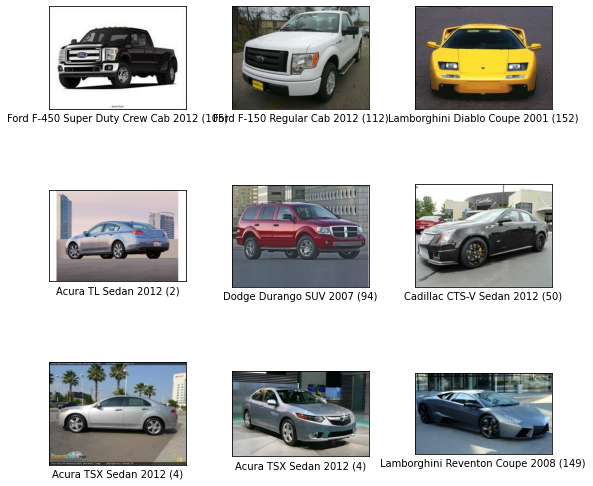

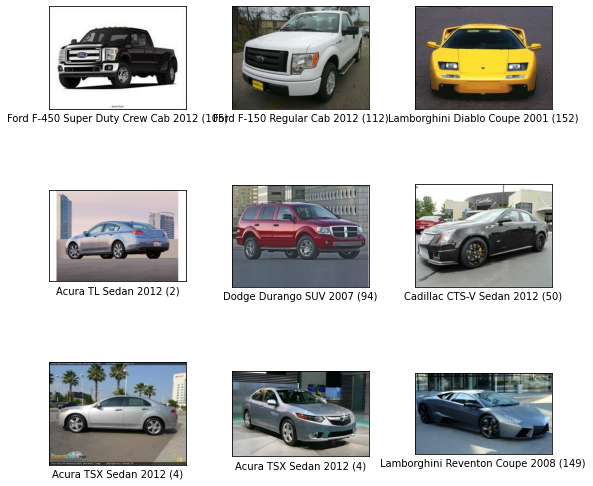

In [5]:
# 이미지 클래스와 인덱스 확인
tfds.show_examples(ds_train, ds_info)

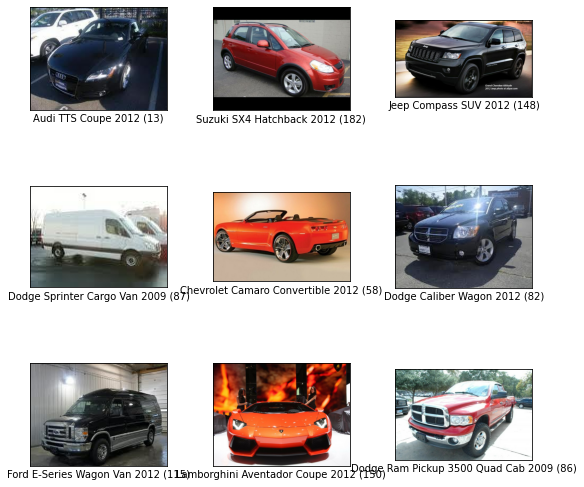

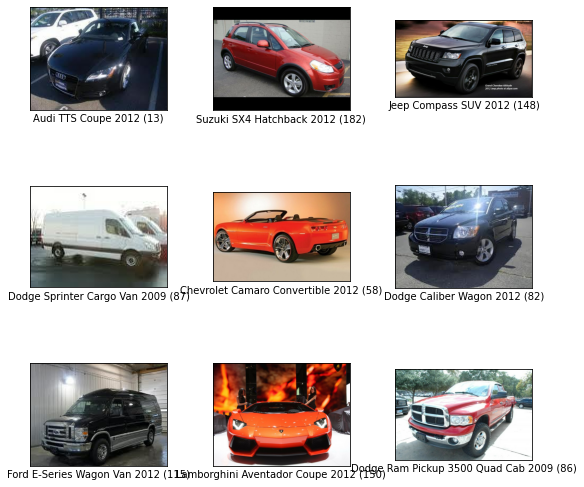

In [6]:
# 평가용 데이터셋 확인
tfds.show_examples(ds_test, ds_info)

In [7]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

## BBoxFeature
- https://www.tensorflow.org/datasets/api_docs/python/tfds/features/BBoxFeature
![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/GC-3-P-2.jpg)

- 바운딩 박스
- 표기법
    + xywh : (x_center, y_center, width, height), 또는 좌측상단 xy
    + minmax : (x_min, x_max, y_min, y_max)
    + 등등등...


In [ ]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',
)
x = base_model.output
# preds = ADD_YOUR_LAYER(x)
cam_model=keras.Model(inputs=base_model.input, outputs=preds)